In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak

In [2]:
# This program plots a per-event array (jet_pt) that has been masked to meet certain conditions (in this case, abs(jet eta) < 1).

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        Jet_axis = hist.Bin("Jet_pt", "Jet_pt [GeV]", 100, 15, 60)
        
        self._accumulator = processor.dict_accumulator({
            'Jet_pt': hist.Hist("Counts", dataset_axis, Jet_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata['dataset']
        
        # NanoEvents allows easy access to our jets with the Jet column.
        jets = events.Jet

        output['cutflow']['all events'] += ak.size(jets, axis=0)
        output['cutflow']['number of jets'] += ak.sum(ak.count(jets, axis=1))
        
        # We want jets with an abs(eta) < 1. Conditionals act on every value in an array in Coffea, so this is easy.
        eta_max = (np.absolute(jets.eta) < 1)
        # eta_max is a Boolean array, with True in the place of values where the condition is met, and False otherwise. We want to sum up all the Trues (=1) in each sublist, then sum up all the sublists to get the number of jets with pt > 20.
        output['cutflow']['abs(eta) < 1'] += ak.sum(ak.sum(eta_max, axis=1))
            
        # We define good_jets as the actual jets we want to graph. We mask it with the jets that have abs(eta) < 1.
        good_jets = jets[eta_max]
        # good_jets is no longer a Boolean array, so we can't just sum up the True's. We count the amount of jets and sum that.
        output['cutflow']['final good jets'] += ak.sum(ak.count(good_jets, axis=1))
        
        output['Jet_pt'].fill(dataset=dataset, Jet_pt=ak.flatten(good_jets.pt))
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

# Our file is missing some cross-references, so we have to make NanoAOD push warnings instead of erroring out.
# This ultimately isn't a problem, it's just a constraint of the public NanoAOD we're using.
processor.NanoAODSchema.warn_missing_crossrefs = True

output = processor.run_uproot_job(fileset=fileset, 
                       treename="Events", 
                       processor_instance=Processor(),
                       executor=processor.futures_executor,
                       executor_args={'schema': processor.NanoAODSchema},
                       chunksize=250000)

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/214 [00:00<?, ?chunk/s]

/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:133: RuntimeWarning: Parsing indexer Muon_genPartIdx, expected to find collection GenPart but did not
  warnings.warn(str(problem), RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:133: RuntimeWarning: Parsing indexer Electron_genPartIdx, expected to find collection GenPart but did not
  warnings.warn(str(problem), RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:133: RuntimeWarning: Parsing indexer Tau_genPartIdx, expected to find collection GenPart but did not
  warnings.warn(str(problem), RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:133: RuntimeWarning: Parsing indexer Photon_genPartIdx, expected to find collection GenPart but did not
  warnings.warn(str(problem), RuntimeWarning)


<AxesSubplot:xlabel='Jet_pt [GeV]', ylabel='Counts'>

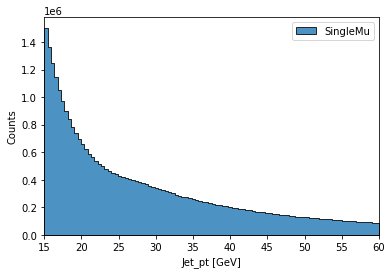

In [4]:
hist.plot1d(output['Jet_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
number of jets 1025717370
abs(eta) < 1 39563735
final good jets 237382410
